In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import mglearn
from tqdm import tqdm, trange
import numpy as np

In [45]:
df = pd.read_csv('./NewsAggregatorDataset/newsCorpora.csv', sep='\t', header=None, names=['ID','TITLE','URL','PUBLISHER','CATEGORY','STORY','HOSTNAME','TIMESTAMP'])
extracted = df[df['PUBLISHER'].isin(['Reuters','Huffington Post','Businessweek','Contactmusic.com','Daily Mail'])]
extracted = extracted[['CATEGORY','TITLE']]

train, val_test = train_test_split(extracted, test_size=0.2, shuffle=True, random_state=1, stratify=extracted["CATEGORY"])

valid, test = train_test_split(val_test, test_size=0.5, shuffle=True, random_state=1, stratify=val_test["CATEGORY"])

In [46]:
df['CATEGORY'].value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [47]:
vectorizer = TfidfVectorizer()
train_v = vectorizer.fit_transform(train['TITLE'])
valid_v = vectorizer.transform(valid['TITLE'])
test_v = vectorizer.transform(test['TITLE'])

train_feature = pd.DataFrame(train_v.toarray(), columns=vectorizer.get_feature_names())
valid_feature = pd.DataFrame(valid_v.toarray(), columns=vectorizer.get_feature_names())
test_feature = pd.DataFrame(test_v.toarray(), columns=vectorizer.get_feature_names())

In [48]:
lr = LogisticRegression(random_state=1, max_iter=10000)
lr.fit(train_feature, train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=1)

In [49]:
def prediction(model, x, y):
    pred = model.predict(x)
    print('prediction:', pred)
    print('confusion matrix:\n',confusion_matrix(y, pred))
    print('accuracy:',accuracy_score(y, pred))

    return pred

In [50]:
def prec_recall_f1(tr, pred, ave='macro'):
    print('precision score:',precision_score(tr, pred, average=ave))
    print('recall score:',recall_score(tr, pred, average=ave))
    print('f1 score:',f1_score(tr, pred, average=ave))

In [51]:
train_pred = prediction(lr, train_feature, train['CATEGORY'])

prediction: ['b' 'b' 'e' ... 'b' 'e' 'b']
confusion matrix:
 [[4418   53    3   28]
 [  18 4201    0    4]
 [  78  117  529    4]
 [ 134  118    3  964]]
accuracy: 0.9475262368815592


In [52]:
valid_pred = prediction(lr, valid_feature, valid['CATEGORY'])

prediction: ['e' 'm' 'e' ... 'b' 't' 'b']
confusion matrix:
 [[529  25   0   9]
 [ 13 514   0   1]
 [ 17  17  54   3]
 [ 43  28   0  81]]
accuracy: 0.8830584707646177


In [53]:
test_pred = prediction(lr, test_feature, test['CATEGORY'])

prediction: ['b' 'b' 'e' ... 'e' 'b' 'e']
confusion matrix:
 [[525  20   2  15]
 [  7 517   0   4]
 [ 20  31  38   2]
 [ 40  24   2  87]]
accuracy: 0.8748125937031485


In [54]:
category = {0:'b', 1:'e', 2:'m', 3:'t'}
tprec = 0
conmat = confusion_matrix(test['CATEGORY'], test_pred)

for c in category.keys():
    print('category: ',category[c])
    prec = conmat[c,c] / sum(conmat[:,c]) * 100
    recall = conmat[c,c] / sum(conmat[c,:]) * 100
    
    print('precision score = ', prec, "%")
    print('recall score = ', recall, "%")
    print('f1 score = ', (2*prec*recall)/(recall+prec), "%\n")

category:  b
precision score =  88.68243243243244 %
recall score =  93.41637010676158 %
f1 score =  90.98786828422877 %

category:  e
precision score =  87.33108108108108 %
recall score =  97.91666666666666 %
f1 score =  92.32142857142857 %

category:  m
precision score =  90.47619047619048 %
recall score =  41.75824175824176 %
f1 score =  57.14285714285715 %

category:  t
precision score =  80.55555555555556 %
recall score =  56.86274509803921 %
f1 score =  66.66666666666667 %



In [55]:
print('\t=== macro ===')
print('precision score:',precision_score(test['CATEGORY'], test_pred, average='macro'))
print('recall score:',recall_score(test['CATEGORY'], test_pred, average='macro'))
print('f1 score:',f1_score(test['CATEGORY'], test_pred, average='macro'))

print('\t=== micro ===')
print('precision score:',precision_score(test['CATEGORY'], test_pred, average='micro'))
print('recall score:',recall_score(test['CATEGORY'], test_pred, average='micro'))
print('f1 score:',f1_score(test['CATEGORY'], test_pred, average='micro'))

	=== macro ===
precision score: 0.8676131488631489
recall score: 0.724885059074273
f1 score: 0.7677970516629529
	=== micro ===
precision score: 0.8748125937031485
recall score: 0.8748125937031485
f1 score: 0.8748125937031486


In [56]:
train.columns.values

array(['CATEGORY', 'TITLE'], dtype=object)

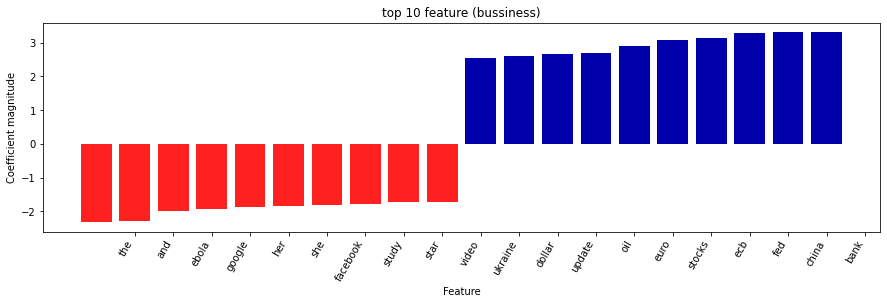

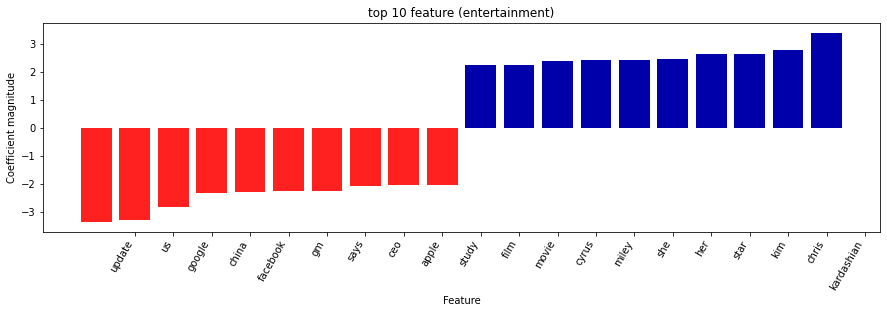

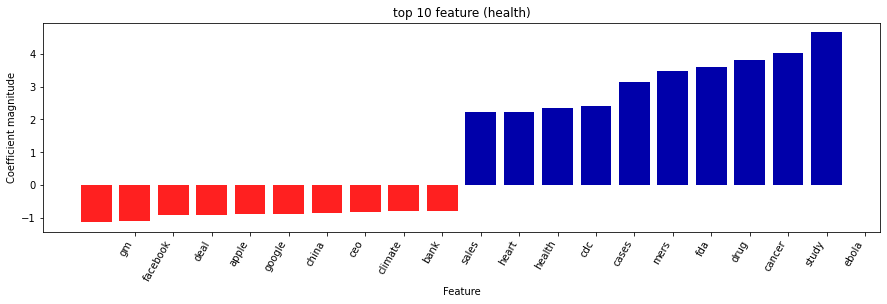

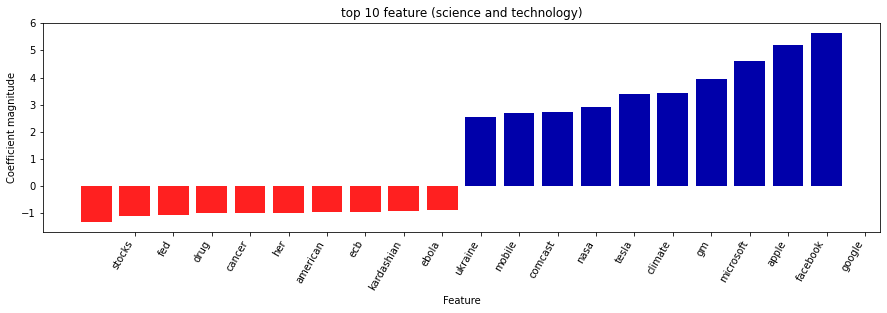

In [58]:
columns = train_feature.columns.values
categoly = ['bussiness', 'entertainment', 'health', 'science and technology']
for i in range(4):
    mglearn.tools.visualize_coefficients(lr.coef_[i,:], columns, n_top_features=10)
    plt.title("top 10 feature ("+categoly[i]+")")
    plt.show()

In [40]:
train_result = []
valid_result = []
test_result = []

param = np.logspace(-5, 5, 11, base=10)
for x in tqdm(param):
    lr = LogisticRegression(C=x, random_state=1, max_iter=10000)
    lr.fit(train_feature, train['CATEGORY'])

    # train
    train_pred = lr.predict(train_feature)
    train_result.append(100*accuracy_score(train['CATEGORY'], train_pred))

    # valid
    valid_pred = lr.predict(valid_feature)
    valid_result.append(100*accuracy_score(valid['CATEGORY'], valid_pred))

    # test
    test_pred = lr.predict(test_feature)
    test_result.append(100*accuracy_score(test['CATEGORY'], test_pred))

plt.plot(param, train_result, label = "train")
plt.plot(param, valid_result, label = "valid")
plt.plot(param, test_result, label = "test")
plt.xscale('log')
plt.xlabel("Inverse of regularization strength")
plt.ylabel("accuracy")
plt.legend()

 82%|████████▏ | 9/11 [13:22<02:58, 89.19s/it] 


KeyboardInterrupt: 

In [ ]:
clst = np.linspace(0.5, 5.0, 10)
wlst = ['balanced', None]
slst = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

best = {'accuracy':0.0, 'c':None, 'w':None, 's':None}

for i in trange(10, desc='c loop'):
    c = clst[i]
    for j in trange(2, desc='w loop', leave=False):
        w = wlst[j]
        for k in trange(5, desc='s loop', leave=False):
            s = slst[k]
            lr = LogisticRegression(C=c, class_weight=w, solver=s, random_state=1, max_iter=10000)
            lr.fit(train_feature, train['CATEGORY'])

            pred = lr.predict(valid_feature)
            acc = 100*accuracy_score(valid['CATEGORY'], pred)
            if best['accuracy'] < acc:
                best['accuracy'] = acc
                best['c'] = c
                best['w'] = w
                best['s'] = s

lr = LogisticRegression(C=best['c'], class_weight=best['w'], solver=best['s'], random_state=1, max_iter=10000)
lr.fit(train_feature, train['CATEGORY'])

pred = lr.predict(test_feature)
acc = 100*accuracy_score(test['CATEGORY'], pred)

print("c:{0}\nw:{1}\ns:{2}\naccuracy:{3}%".format(best['c'],best['w'],best['s'],acc))